In [1]:
#package imports
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import sys
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sys.path.append('../')
from src.models import aerial_cnn
sys.path.append('/notebook')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
% matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

### Input Data Prep

In [2]:
sam1= pd.read_csv('../labels/training_labels_updated_111219.csv')
sam2 = pd.read_csv('../labels/additional_training_labels_120319.csv')
sample=pd.concat([sam1, sam2], axis = 0)
assert sample.shape[0] == sam1.shape[0] + sam2.shape[0]

# option to include additional labels - trained with these on a GPU
# sample3 = pd.read_csv('../labels/new6000_training_labels_aerial.csv', index_col='Unnamed: 0') 

In [3]:
# take a look at the top
sample.head()

,ADDRESS_FOR_STREET_VIEW,ADDR_NUM,AERIAL_Driveway,FULL_STR,GSV_Driveway,MBL,aerial_addr,aerial_filename,final_label,gsv_filename,sv_addr,three_class_label
0,"5 DOUGLAS AVE, SOMERVILLE, MA",5,2.0,DOUGLAS AVE,0.0,47-G-17,NaN,5_DOUGLAS_AVE_aerial.png,0.1,5_DOUGLAS_AVE.jpg,NaN,NaN
1,"6 HILLSIDE CIR, SOMERVILLE, MA",6,1.0,HILLSIDE CIR,2.0,38-A-47,NaN,6_HILLSIDE_CIR_aerial.png,0.9,6_HILLSIDE_CIR.jpg,NaN,NaN
2,"8 BELMONT PL, SOMERVILLE, MA",8,2.0,BELMONT PL,2.0,44-A-48,NaN,8_BELMONT_PL_aerial.png,0.5,8_BELMONT_PL.jpg,NaN,NaN
3,"8 DRESDEN CIR, SOMERVILLE, MA",8,2.0,DRESDEN CIR,2.0,25-A-13,NaN,8_DRESDEN_CIR_aerial.png,0.5,8_DRESDEN_CIR.jpg,NaN,NaN
4,"8 HAWTHORNE ST, SOMERVILLE, MA",8,0.0,HAWTHORNE ST,2.0,25-D-16,NaN,8_HAWTHORNE_ST_aerial.png,0.1,8_HAWTHORNE_ST.jpg,NaN,NaN


In [4]:
# This is the aerial model - train on aerial driveway labels
sample['AERIAL_Driveway'] = sample['AERIAL_Driveway'].astype('int').astype('str')

In [5]:
sample.loc[sample['AERIAL_Driveway'] == '2', 'AERIAL_Driveway'] = '0'

In [6]:
# now split into train and validation (calling it test here)
train_data, test_data = train_test_split(sample, test_size = 0.2, random_state = 100)
y_column = 'AERIAL_Driveway'

For aerial driveways, we have three labelled classes (0: no driveway; 1: driveway; 2: unsure)  
We tried two variants of models:
1. Learn these three classes
2. Set 0 and 2 to be the same class - we want to be able to predict the driveways accurately

This notebook shows option 2.

### Minority class oversampling

In [7]:
display(train_data.groupby(y_column).aggregate({'MBL':len}))
display(test_data.groupby(y_column).aggregate({'MBL':len}))

,MBL
AERIAL_Driveway,
0,216
1,304


,MBL
AERIAL_Driveway,
0,50
1,80


In [8]:
# artificially oversample the minority class - TRAINING
zero_class = train_data[train_data[y_column] == '0']
one_class = train_data[train_data[y_column] == '1']

train_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0]-1):
    train_data = train_data.append(zero_class)

In [9]:
# artificially oversample the minority class - TEST
zero_class = test_data[test_data[y_column] == '0']
one_class = test_data[test_data[y_column] == '1']

test_data = one_class.append(zero_class)
for i in range(one_class.shape[0]//zero_class.shape[0]-1):
    test_data = test_data.append(zero_class)

In [10]:
# display(train_data.groupby(y_column).aggregate({'MBL':len}))
# display(test_data.groupby(y_column).aggregate({'MBL':len}))

### Modelling

In [11]:
# set input params
aer_image_dim = (150, 150, 3)
lr = 1e-4
batch_size = 256
val_batch_size = 256

In [ ]:
# define optimizer - adam 
optimizer = keras.optimizers.Adam(lr=lr)

# define learning rate decay method - two options
# lr_decay = tensorflow.keras.callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.9 ** epoch)) 
lr_decay = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.05, 
                                                        patience=2, 
                                                        verbose=True, 
                                                        mode='auto',
                                                        min_delta=0.0001, 
                                                        cooldown=1, 
                                                        min_lr=1e-6)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=0.01,
                                               patience=3, 
                                               verbose=True,
                                               mode='auto', 
                                               baseline=None)

# define loss - cat xentropy
# loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.2) #smoothed labels
loss = keras.losses.BinaryCrossentropy(label_smoothing=0.2) #smoothed labels

In [16]:
# define pretrained model 
pretrained_model = keras.applications.ResNet50(include_top=False, input_shape=aer_image_dim, pooling = 'avg')
print('number of layers in pretrained model: ', len(pretrained_model.layers))

# I tried unfreezing none to some - more fine tuning required here but not sure it makes much of a diff atm
for layer in pretrained_model.layers[:-60]:
    layer.trainable = False

number of layers in pretrained model:  176


In [17]:
# build model using function from models.py
model = aerial_cnn(pretrained_model, 
                        image_dim = aer_image_dim, 
                        optimizer = optimizer,
                        loss = loss,
                        n_classes=3,
                        activation = 'sigmoid',
                        metrics=['accuracy'], 
                       )
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
satellite_image_input (Input [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_______________________________________________

### Generator

In [18]:
# parameters
image_dir = '../data/aerial_all/'
x_column = 'aerial_filename'
color_mode = 'rgb'
drop_channel = lambda x: x[:,:,0:3]

In [19]:
gen_obj = ImageDataGenerator(preprocessing_function=drop_channel,
                                    rescale=1.0/255.0,
                                    horizontal_flip = True, vertical_flip = True, 
                                    width_shift_range = 0.1, height_shift_range = 0.1, 
                                    zoom_range = 0.1, rotation_range = 50)

## train
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=batch_size, 
                                            shuffle=True,
                                            seed=10)

## test (i.e. validation)
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=val_batch_size, 
                                            shuffle=True,
                                            seed=10)

Found 7096 validated image filenames belonging to 2 classes.
Found 1767 validated image filenames belonging to 2 classes.


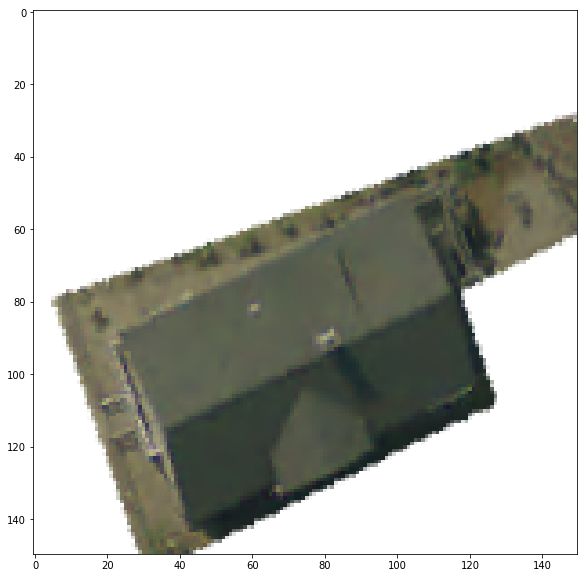

In [21]:
## check that the generator works
# store = next(train_generator)
# plt.figure(figsize = (10,10));plt.imshow(store[0][10])

### Training

In [22]:
# training parameters
epochs = 35
val_steps = test_data.shape[0]//val_batch_size

# train model
history = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps,
                              epochs=epochs,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1,
                              callbacks=[lr_decay, early_stopping])

Epoch 1/35
27/27 [==============================] - 367s 14s/step - loss: 3.2327 - acc: 0.6167 - val_loss: 3.2656 - val_acc: 0.5000
Epoch 2/35
27/27 [==============================] - 351s 13s/step - loss: 3.0051 - acc: 0.7060 - val_loss: 3.0794 - val_acc: 0.5000
Epoch 3/35
27/27 [==============================] - 339s 13s/step - loss: 2.8177 - acc: 0.7572 - val_loss: 2.9145 - val_acc: 0.4980
Epoch 4/35
27/27 [==============================] - 340s 13s/step - loss: 2.6445 - acc: 0.7906 - val_loss: 2.7608 - val_acc: 0.4967
Epoch 5/35
27/27 [==============================] - 320s 12s/step - loss: 2.4741 - acc: 0.8296 - val_loss: 2.6257 - val_acc: 0.4912
Epoch 6/35
27/27 [==============================] - 312s 12s/step - loss: 2.3151 - acc: 0.8645 - val_loss: 2.4985 - val_acc: 0.4821
Epoch 7/35
27/27 [==============================] - 298s 11s/step - loss: 2.1621 - acc: 0.8943 - val_loss: 2.3897 - val_acc: 0.4909
Epoch 8/35
27/27 [==============================] - 303s 11s/step - loss: 2.

In [24]:
history1 = model.fit_generator(generator=train_generator, 
                              validation_data=test_generator, 
                              validation_steps=val_steps,
                              epochs=10,
                              steps_per_epoch=np.ceil(train_data.shape[0]//batch_size),
                              verbose=1,
#                               callbacks=[lr_decay, early_stopping]
                             )

Epoch 1/10
27/27 [==============================] - 367s 14s/step - loss: 0.6329 - acc: 0.9928 - val_loss: 1.0772 - val_acc: 0.4909
Epoch 2/10
27/27 [==============================] - 354s 13s/step - loss: 0.6305 - acc: 0.9937 - val_loss: 1.0752 - val_acc: 0.4909
Epoch 3/10
27/27 [==============================] - 341s 13s/step - loss: 0.6285 - acc: 0.9948 - val_loss: 1.0743 - val_acc: 0.4909
Epoch 4/10
27/27 [==============================] - 332s 12s/step - loss: 0.6279 - acc: 0.9948 - val_loss: 1.0694 - val_acc: 0.4909
Epoch 5/10
27/27 [==============================] - 319s 12s/step - loss: 0.6259 - acc: 0.9953 - val_loss: 1.0671 - val_acc: 0.4909
Epoch 6/10
27/27 [==============================] - 308s 11s/step - loss: 0.6251 - acc: 0.9951 - val_loss: 1.0665 - val_acc: 0.4909
Epoch 7/10
27/27 [==============================] - 309s 11s/step - loss: 0.6229 - acc: 0.9957 - val_loss: 1.0674 - val_acc: 0.4909
Epoch 8/10
27/27 [==============================] - 299s 11s/step - loss: 0.

In [31]:
hist = {}
for key in list(history.history.keys())[:-1]:
    hist[key] = history.history[key] + history1.history[key] 

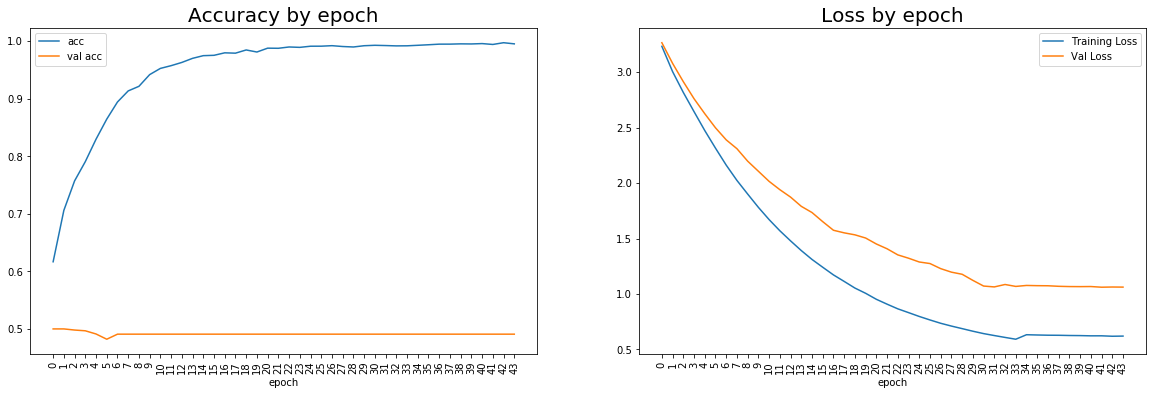

In [33]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.plot(hist['acc'], label = 'acc')
plt.plot(hist['val_acc'], label = 'val acc')
plt.title('Accuracy by epoch', fontsize = 20)
plt.xticks(np.arange(0,len(hist['acc'])), rotation = 90);plt.xlabel('epoch')
plt.legend();

plt.subplot(1,2,2)
plt.plot(hist['loss'], label = 'Training Loss')
plt.plot(hist['val_loss'], label = 'Val Loss')
plt.title('Loss by epoch', fontsize = 20)
plt.xticks(np.arange(0,len(hist['acc'])), rotation = 90); plt.xlabel('epoch')
plt.legend();

### Make Predictions

In [37]:
## TRAIN ACCURACY
train_data, test_data = train_test_split(sample, test_size = 0.2, random_state = 100)

gen_obj = ImageDataGenerator(rescale=1.0/255.0)
train_generator = gen_obj.flow_from_dataframe(train_data, 
                                            directory = image_dir,  
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=train_data.shape[0], 
                                            shuffle=False, 
                                            seed=1)

train_preds = model.predict_generator(train_generator, steps = 1)
train_data['predicted_label'] = np.argmax(train_preds, axis = 1)
sum(train_data[y_column].astype('int') == train_data.predicted_label.astype('int'))/len(train_data)

Found 3906 validated image filenames belonging to 2 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.0742447516641065

In [39]:
## TEST ACCURACY
test_gen_obj = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_gen_obj.flow_from_dataframe(test_data, 
                                            directory = image_dir, 
                                            x_col= x_column, 
                                            y_col= y_column, 
                                            target_size=(aer_image_dim[0], aer_image_dim[1]), 
                                            color_mode=color_mode, 
                                            class_mode='categorical',
                                            batch_size=test_data.shape[0], 
                                            shuffle=False,
                                            seed=10)

test_preds = model.predict_generator(test_generator, steps = 1)
test_data['predicted_label'] = np.argmax(test_preds, axis = 1)
sum(test_data[y_column].astype('int') == test_data.predicted_label.astype('int'))/len(test_data)

0.08085977482088025

### Visualization of results 
Clearly, the model is not able to distinguish between the two classes. Also, predicted probabilities, while not at 0.5, are not super confident (centered around 0.3 and 0.7)

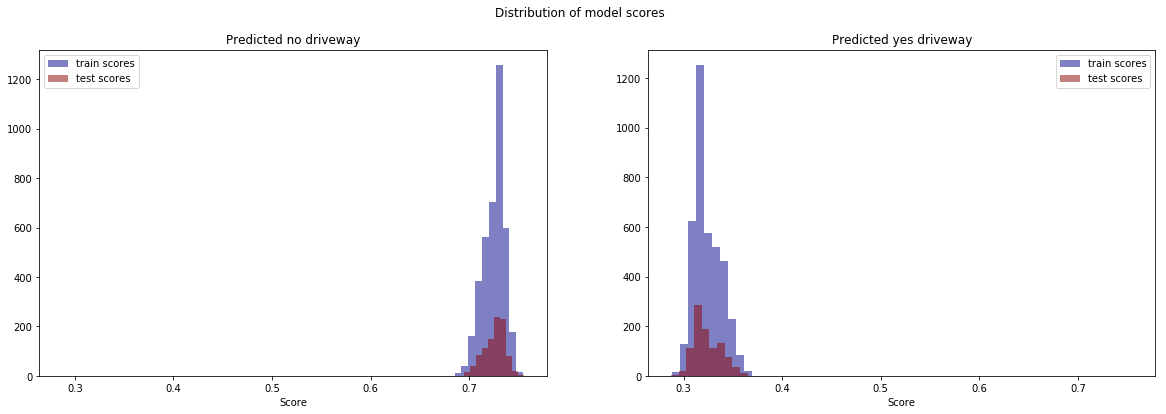

In [40]:
# binary prediction
if len(train_preds.shape) == 1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))

    ax.hist(train_preds, color='darkblue', alpha=0.5, label='train scores')
    ax.hist(test_preds, color='darkred', alpha=0.5, label='test scores')
    ax.legend()
    ax.set_xlabel('Score')
    ax.set_title('Distribution of model scores');
    
elif len(train_preds.shape) > 1:
    label_map = {0: 'Predicted no driveway', 1: 'Predicted yes driveway', 2: 'Predicted unsure'}
    fig, ax = plt.subplots(1, train_preds.shape[1], sharex=True, figsize=(20,6))
    
    for i in range(train_preds.shape[1]):
        ax[i].hist(train_preds[:,i], color='darkblue', alpha=0.5, label='train scores')
        ax[i].hist(test_preds[:,i], color='darkred', alpha=0.5, label='test scores')
        ax[i].legend()
        ax[i].set_xlabel('Score')
        ax[i].set_title(label_map[i])
    fig.suptitle('Distribution of model scores');

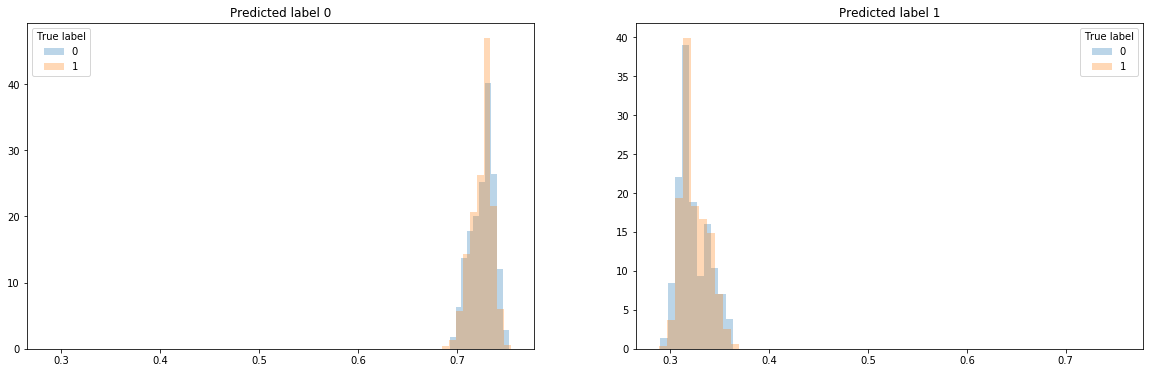

In [43]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20,6))
for i in range(train_preds.shape[1]):
#     print(i)
    for lab in ['0','1']:
        ax[i].hist(train_preds[train_data[y_column]==lab,i], alpha=0.3, density=True, label=lab)
    ax[i].legend(title='True label');
    ax[i].set_title('Predicted label ' + str(i))

### Save Models

In [34]:
model.save('../models/aerial_transfer_model_augmdata.h5')

In [35]:
model.save_weights('../models/aerial_transfer_model_augmdata_weights.h5')

### Load Models

In [11]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras import backend as K

# def sensitivity(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         return true_positives / (possible_positives + K.epsilon())

# def specificity(y_true, y_pred):
#         true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
#         possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
#         return true_negatives / (possible_negatives + K.epsilon())
    
# loaded_model = load_model('../models/aerial_transfer_model.h5')